### 全華， 用機器學習掌握人工智慧， 徐聖訓
### https://drive.google.com/drive/folders/1gfItaJzpfBsRqdXKs-oiTVg3O4lzBXQY?usp=sharing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['DFKai-sb'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('titanic_train.csv')
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
pd.concat([df['Survived'].value_counts(),
          df['Survived'].value_counts(normalize=True)], 
          axis=1, keys=['個數','百分比'])

,個數,百分比
0,549,0.616162
1,342,0.383838


In [6]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


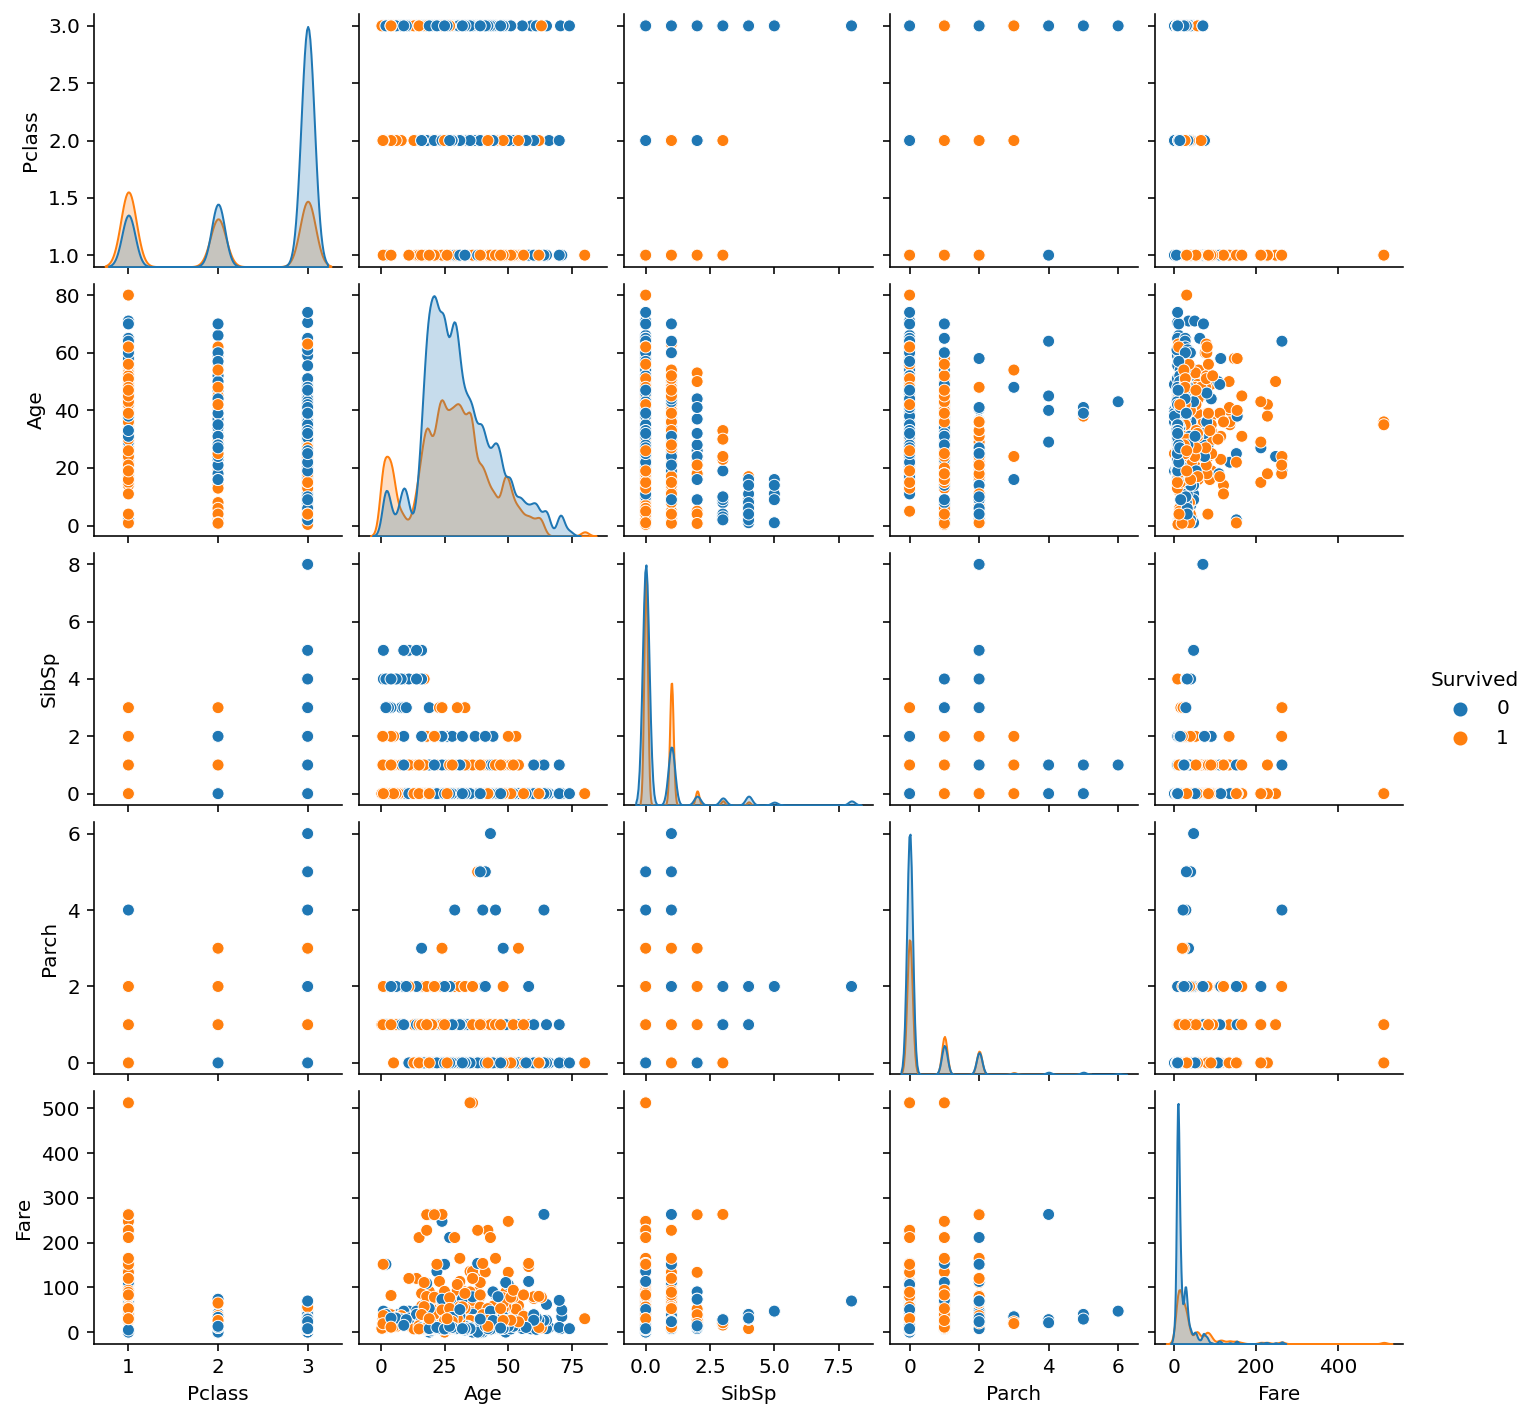

In [8]:
sns.pairplot(data=df, hue='Survived',
             size=2, diag_kws={'bw':0.1});

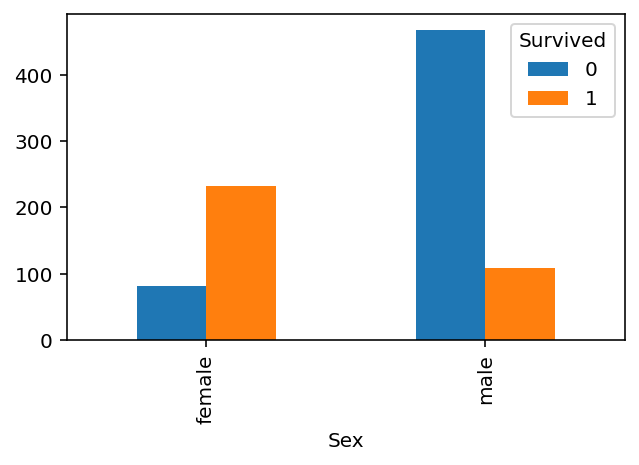

In [9]:
df.groupby('Sex')['Survived'].value_counts().\
unstack(1).plot(kind='bar', figsize=(5,3));

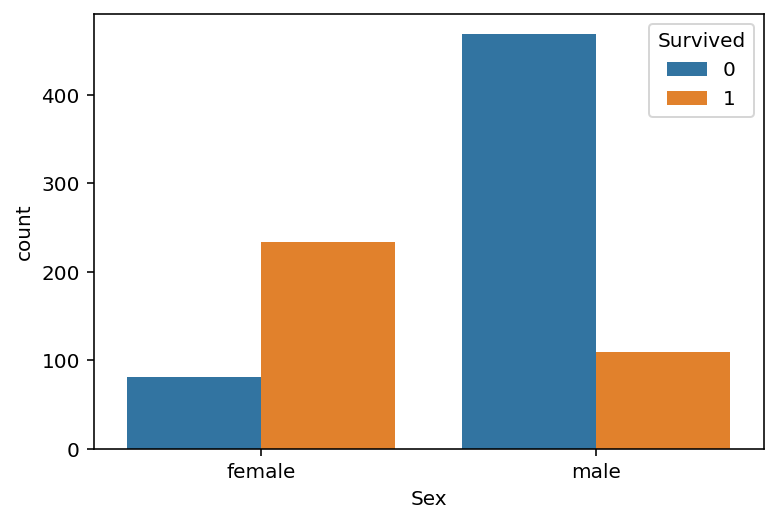

In [10]:
sns.countplot(x='Sex', order=['female','male'], 
              hue='Survived', data=df);

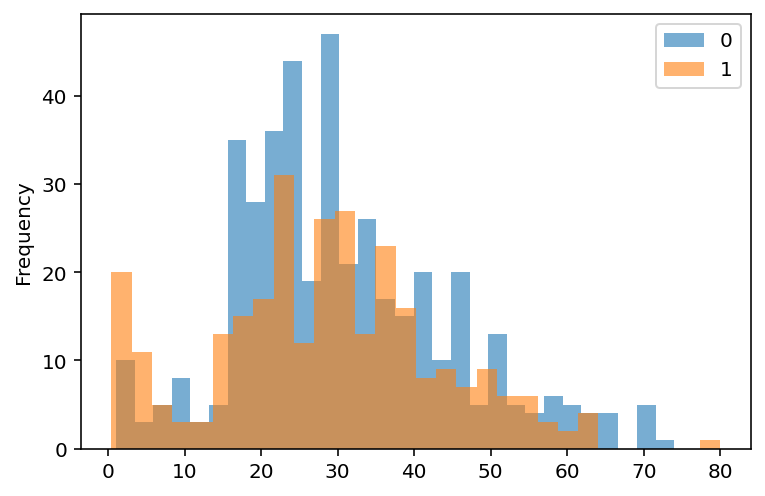

In [11]:
df.groupby('Survived')['Age'].plot(kind='hist', alpha=0.6, 
                                   bins=30, legend=True);

In [12]:
X_col_num = ['Age', 'SibSp', 'Parch', 'Fare']
X_col_cat = ['Pclass', 'Sex', 'Embarked']
X_cols = X_col_num + X_col_cat
y_col = 'Survived'

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
num_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
#檢查數值管道器的運作  
print(f'數值型資料的欄位有：{X_col_num}')
num_pl.fit_transform(df[X_col_num])[:3]

數值型資料的欄位有：['Age', 'SibSp', 'Parch', 'Fare']


array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426]])

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False)
)
# 檢查類別管道器的運作  
cat_pl.fit_transform(df[X_col_cat])[:3]

array([[0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.]])

In [15]:
oh = cat_pl.named_steps['onehotencoder']
oh_cols = oh.get_feature_names(X_col_cat)
oh_cols

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [16]:
pd.DataFrame(cat_pl.fit_transform(df[X_col_cat]), 
             columns=oh_cols).head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [17]:
from sklearn.compose import ColumnTransformer
data_pl = ColumnTransformer([
    ('num_pl', num_pl, X_col_num),
    ('cat_pl', cat_pl, X_col_cat)
])
data_pl.fit_transform(df[X_cols])[:1].round(2)

array([[-0.57,  0.43, -0.47, -0.5 ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  1.  ]])

In [18]:
from sklearn.model_selection import train_test_split
X = df[X_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
from sklearn.svm import SVC
model_pl_svc = make_pipeline(data_pl, SVC())
model_pl_svc

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_pl',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                               

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

正確率： 0.83
混亂矩陣
[[158  17]
 [ 32  88]]
綜合報告
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       175
           1       0.84      0.73      0.78       120

    accuracy                           0.83       295
   macro avg       0.83      0.82      0.82       295
weighted avg       0.83      0.83      0.83       295



In [21]:
from sklearn.linear_model import LogisticRegression
model_pl_lr = make_pipeline(data_pl, LogisticRegression())
model_pl_lr.fit(X_train, y_train)
y_pred = model_pl_lr.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

正確率： 0.81
混亂矩陣
[[154  21]
 [ 35  85]]
綜合報告
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       175
           1       0.80      0.71      0.75       120

    accuracy                           0.81       295
   macro avg       0.81      0.79      0.80       295
weighted avg       0.81      0.81      0.81       295



In [22]:
data_pl = ColumnTransformer([
    ('num_pl', num_pl, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
    ('cat_pl', cat_pl, ['Sex', 'Embarked'])
])
model_pl_svc = make_pipeline(data_pl, SVC())
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))

正確率： 0.84
混亂矩陣
[[159  16]
 [ 32  88]]


In [23]:
from sklearn.feature_selection import SelectKBest, f_classif
data_pl = ColumnTransformer([
    ('num_pl', num_pl, X_col_num),
    ('cat_pl', cat_pl, X_col_cat)
])
model_pl_svc = make_pipeline(data_pl, 
                             SelectKBest(f_classif, 3), 
                             SVC())
model_pl_svc.fit(X_train, y_train)
y_pred = model_pl_svc.predict(X_test)
print('正確率：', accuracy_score(y_test, y_pred).round(2))
print('混亂矩陣')
print(confusion_matrix(y_test, y_pred))

正確率： 0.77
混亂矩陣
[[170   5]
 [ 62  58]]


In [24]:
# 先取到所有欄位名稱含獨熱編碼的欄位
cols = X_col_num + oh_cols.tolist()
selector = model_pl_svc.named_steps['selectkbest']
# 先將資料變成array的資料型態，再用布林值取出欄位名稱
np.array(cols)[selector.get_support()]

array(['Pclass_3', 'Sex_female', 'Sex_male'], dtype='<U10')

In [25]:
from sklearn.preprocessing import KBinsDiscretizer
# 欄位
X_col_num = ['Fare', 'Age']
X_col_bin = ['SibSp', 'Parch']
X_col_cat = ['Pclass', 'Sex', 'Embarked']
# 資料管道器
num_pl = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
bin_pl = make_pipeline(
    SimpleImputer(strategy='mean'),
    KBinsDiscretizer(n_bins=5, encode='ordinal'),
)
cat_pl = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder()
)
# 合併後的資料管道器
data_pl = ColumnTransformer([
    ('num', num_pl, X_col_num),
    ('bin', bin_pl, X_col_bin),
    ('cat', cat_pl, X_col_cat)
])
# 模型預測
model_pl = make_pipeline(data_pl, SVC())
model_pl.fit(X_train, y_train)
y_pred = model_pl.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('整體正確率:',accuracy_score(y_test, y_pred).round(2))

[[163  12]
 [ 45  75]]
整體正確率: 0.81
